# 1번

In [1]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv("machine.data.csv")

# 데이터 확인
print(data.head())


  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP
0    adviser     32/60   125   256   6000   256     16    128  198
1     amdahl    470v/7    29  8000  32000    32      8     32  269
2     amdahl   470v/7a    29  8000  32000    32      8     32  220
3     amdahl   470v/7b    29  8000  32000    32      8     32  172
4     amdahl   470v/7c    29  8000  16000    32      8     16  132


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# 특징 열과 타겟 변수 분리
X = data.drop("PRP", axis=1)
y = data["PRP"]

# 범주형 변수와 수치형 변수 구분
categorical_cols = [col for col in X.columns if X[col].dtype == "object"]
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# 전처리 파이프라인 정의
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 모델 정의
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42))
]

# 파이프라인 정의
pipelines = []
for name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipelines.append((name, pipeline))


In [3]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# 모델 훈련 및 평가
results = []
for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    cv_score = cross_val_score(pipeline, X, y, cv=5).mean()
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((name, train_score, test_score, cv_score, mse))


In [5]:
# 결과 출력
results_df = pd.DataFrame(results, columns=['Model', 'Train Score', 'Test Score', 'CV Score', 'Mean Squared Error'])
print(results_df)


               Model  Train Score  Test Score  CV Score  Mean Squared Error
0  Linear Regression     1.000000    0.902007  0.552339         4988.536992
1      Random Forest     0.952771    0.830125  0.731262         8647.819340


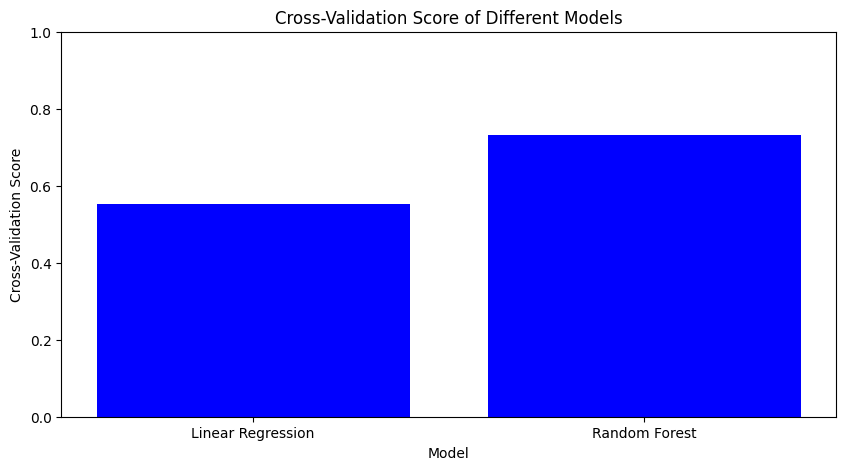

In [7]:
import matplotlib.pyplot as plt

# 분석 결과 시각화
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['CV Score'], color='blue')
plt.title('Cross-Validation Score of Different Models')
plt.xlabel('Model')
plt.ylabel('Cross-Validation Score')
plt.ylim(0, 1)
plt.show()


# 2번

In [8]:
from sklearn.model_selection import GridSearchCV

# GridSearchCV를 위한 하이퍼파라미터 그리드 정의
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 5, 10, 15],
    # 다른 하이퍼파라미터도 필요에 따라 추가 가능
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(pipelines[1][1], param_grid, cv=5, scoring='neg_mean_squared_error')

# 모델 훈련
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['VendorName',
                                                                          'ModelName'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [None, 5, 10, 15],
                         'model__n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 최적의 모델
best_model = grid_search.best_estimator_

# 훈련 데이터 평가
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_cv_score = cross_val_score(best_model, X_train, y_train, cv=5).mean()

print("Training Set Evaluation:")
print("Mean Squared Error:", train_mse)
print("Mean Absolute Error:", train_mae)
print("R^2 Score:", train_r2)
print("Cross-Validation Score:", train_cv_score)


Training Set Evaluation:
Mean Squared Error: 791.40525241653
Mean Absolute Error: 11.13245009997426
R^2 Score: 0.9588334016754763
Cross-Validation Score: 0.7883411511246027


In [10]:
# 테스트 데이터 평가
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_cv_score = cross_val_score(best_model, X_test, y_test, cv=5).mean()

print("\nTest Set Evaluation:")
print("Mean Squared Error:", test_mse)
print("Mean Absolute Error:", test_mae)
print("R^2 Score:", test_r2)
print("Cross-Validation Score:", test_cv_score)



Test Set Evaluation:
Mean Squared Error: 8939.522408383104
Mean Absolute Error: 36.900233513594856
R^2 Score: 0.8243945195802651
Cross-Validation Score: -0.01907841299988262


# 3번

In [21]:
from sklearn.ensemble import RandomForestRegressor

# GridSearchCV를 위한 하이퍼파라미터 그리드 정의
param_grid = {
    'model__n_estimators': [100, 150, 200],  # 트리의 개수를 늘림
    'model__max_depth': [10, 15, 20],  # 트리의 깊이를 증가시킴
    # 다른 하이퍼파라미터도 필요에 따라 추가 가능
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(pipelines[1][1], param_grid, cv=5, scoring='r2')

# 모델 훈련
grid_search.fit(X_train, y_train)

# 최적의 모델
best_model = grid_search.best_estimator_

# 테스트 데이터 평가
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test R^2 Score:", test_r2)


Test R^2 Score: 0.8346380196141586


               Model   Train MSE  Train MAE  Train R^2  Train CV Score  \
0  Linear Regression    0.000006   0.001600   1.000000        0.608541   
1      Random Forest  907.946169  10.922335   0.952771        0.779461   

      Test MSE   Test MAE  Test R^2  Test CV Score  
0  4988.536992  46.652928  0.902007      -0.028463  
1  8647.819340  36.191190  0.830125      -0.053047  


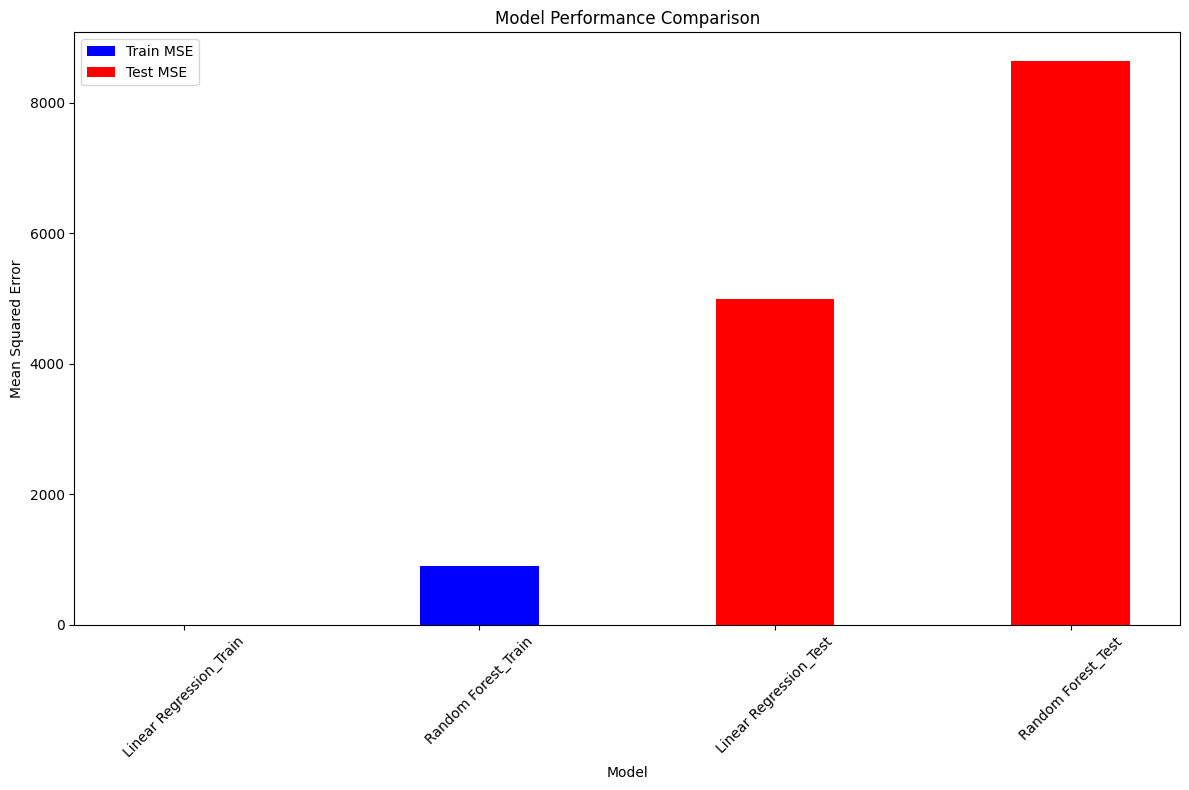

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 성능 지표 저장을 위한 빈 리스트 생성
performance_results = []

# 각 모델에 대해 성능 지표 계산 및 저장
for name, pipeline in pipelines:
    # 모델 훈련
    pipeline.fit(X_train, y_train)
    
    # 훈련 데이터 평가
    y_train_pred = pipeline.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_cv_score = cross_val_score(pipeline, X_train, y_train, cv=5).mean()
    
    # 테스트 데이터 평가
    y_test_pred = pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_cv_score = cross_val_score(pipeline, X_test, y_test, cv=5).mean()
    
    # 결과 저장
    performance_results.append((name, train_mse, train_mae, train_r2, train_cv_score, test_mse, test_mae, test_r2, test_cv_score))

# 결과를 데이터프레임으로 변환
columns = ['Model', 'Train MSE', 'Train MAE', 'Train R^2', 'Train CV Score', 'Test MSE', 'Test MAE', 'Test R^2', 'Test CV Score']
performance_df = pd.DataFrame(performance_results, columns=columns)

# 결과 출력
print(performance_df)

# 바 차트로 시각화
plt.figure(figsize=(12, 8))

# 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이 비교
plt.bar(performance_df['Model'] + '_Train', performance_df['Train MSE'], width=0.4, color='b', label='Train MSE')
plt.bar(performance_df['Model'] + '_Test', performance_df['Test MSE'], width=0.4, color='r', label='Test MSE')

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
